In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import chi2

from tqdm import trange

In [2]:
mpl.rc('font', size=18)

## Set up $\chi^2$ fit functions

Fit functions:

$$
y = a + bx
$$

and 

$$
y = a + bx + cx^2.
$$

In [3]:
def chi2l(params, x, y, sigma):
    a, b = params
    return np.sum(((y - (a + b*x)) / sigma)**2)

def chi2q(params, x, y, sigma):
    a, b, c = params
    return np.sum(((y - (a + b*x + c*x**2)) / sigma)**2)

## Build $N$ fake datasets, fit $\chi^2$, compute $\Delta\chi^2$

In [4]:
# Independent variable.
N = 10
x = np.linspace(1, 10, N)

# Parameters of the model y = a + bx + cx^2
a, b, c = 1., 2., 0.
sigma_y = 2.

# Generate random data.
Nmc = 10000
dchi2 = []

for i in trange(0, Nmc):
    y = a + b*x + c*x**2 + sigma_y*np.random.randn(10)

    resl = minimize(chi2l, [0.8, 2.2], args=(x,y,sigma_y), method='BFGS')
    resq = minimize(chi2q, [0.8, 2.2, 0.4], args=(x,y,sigma_y), method='BFGS')

    if resl.success and resq.success:
        dchi2.append(resl.fun - resq.fun)

/lib/python3.10/site-packages/tqdm/std.py:1541: TqdmMonitorWarning: tqdm:disabling monitor support (monitor_interval = 0) due to:
can't start new thread
  return tqdm(_range(*args), **kwargs)
100%|██████████| 10000/10000 [01:02<00:00, 158.96it/s]


## Compute the mean and variance of $\Delta\chi^2$

Since there is one difference in the degree of freedom of the two fit functions, we expect

$$
\Delta\chi^2 = \chi^2_\mathrm{lin} - \chi^2_\mathrm{quad} \sim \chi^2_1.
$$

The mean and variance of $\chi^2_k$, where $k$ is the number of degrees of freedom, is

$$
\begin{align*}
  &k, &2k,
\end{align*}
$$

so we expect the mean and variance to be $1$ and $2$.

In [5]:
print(np.mean(dchi2), np.std(dchi2)**2)

1.0182189439931506 2.0944513526061326


## Plot the distribution of $\Delta\chi^2$.

Under the null hypothesis, the normalized histogram of $\Delta\chi^2$ should be distributed as $\chi^2_1$.

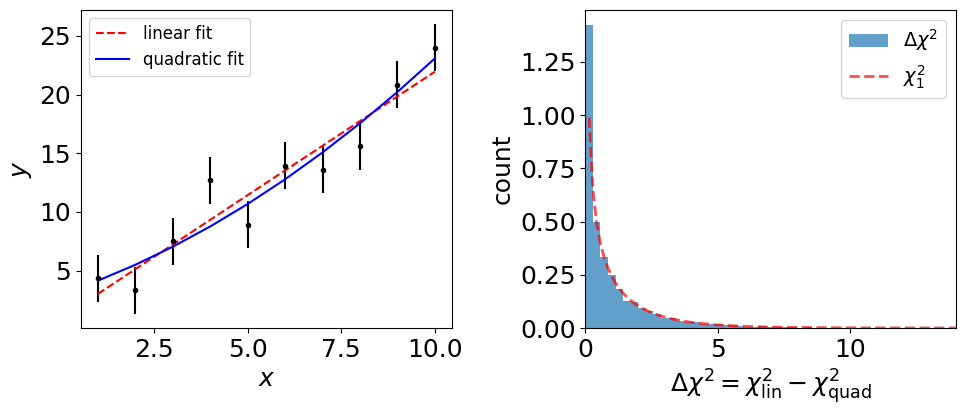

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4.5), tight_layout=True)

ax1.errorbar(x, y, yerr=sigma_y, fmt='.', color='k')
a, b = resl.x
ax1.plot(x, a + b*x, 'r--', label='linear fit')

a, b, c = resq.x
ax1.plot(x, a + b*x + c*x**2, 'b-', label='quadratic fit')

ax1.set(xlabel='$x$', ylabel='$y$')
ax1.legend(fontsize=12)

# Histogram the delta-chi2 values.
dmin = np.floor(np.min(dchi2))
dmax = np.ceil(np.max(dchi2))
ax2.hist(dchi2, bins=np.linspace(dmin, dmax, 50),
         alpha=0.7, density=True, label=r'$\Delta\chi^2$')

# Plot the chi2 function with 1 DOF.
df = 1
_x = np.linspace(dmin, dmax, 100)
rv = chi2(df)
ax2.plot(_x, rv.pdf(_x), color='r', alpha=0.7, ls='--', lw=2, label=rf'$\chi^2_{df}$')

ax2.set(xlabel=r'$\Delta\chi^2=\chi^2_{\mathrm{lin}}-\chi^2_{\mathrm{quad}}$',
        xlim=(dmin, dmax),
        ylabel='count')

ax2.legend(fontsize=14);